# Unsupervised Learning

## k-means

𝘬-means is one of the most popular clustering algorithms. In this algorithm, a user-specified number of clusters (𝘬) are randomly assigned to different points in the dataset. The unassigned points are then “assigned” to a cluster based on their proximity (measured in Euclidean distance) to the previously assigned point. Once this assignment happens, the center of this cluster (called the centroid) is computed, and the process repeats. All points are assigned to a particular centroid, and a new centroid is computed. We repeat this process for a finite number of iterations or until convergence (i.e., when our centroid locations stop changing). This does not, however, mean that our clusters are always sensical. For instance, a given “logical” cluster of data might be split right down the middle simply because of the starting points of two distinct clusters. Thus, it is often a good idea to perform multiple runs of 𝘬-means starting with different initializations.

Install seaborn by uncommenting the following cell:

In [27]:
#!conda install seaborn

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.6.12               |           py36_1         2.1 MB
    patsy-0.5.1                |           py36_0         380 KB
    scipy-1.2.1                |   py36h7c811a0_0        17.7 MB
    seaborn-0.9.0              |           py36_0         379 KB
    statsmodels-0.9.0          |   py36h035aef0_0         9.0 MB
    ------------------------------------------------------------
                                           Total:        29.6 MB

The following NEW packages will be INSTALLED:

  patsy              pkgs/main/linux-64::patsy-0.5.1-py36_0
  scipy              pkgs/main/linux-64::scipy-1.2.1-py36h7c811a0_0
  seaborn            pkgs/main/linux-64::seaborn-0.9.0-py36_0
  statsmodels        pkgs/main/linux-64

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# the following line gets the bucket name attached to our cluster
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")

# specifying the path to our bucket where the data is located (no need to edit this path anymore)
data = "gs://" + bucket + "/notebooks/data/"
print(data)

gs://is843/notebooks/data/


In [11]:
df = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(data + "iris.csv")\
  .coalesce(5)

df = df.drop('_c0')
df.cache()
df.show(1)
df.printSchema()
print("This datasets consists of {} rows.".format(df.count()))

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 1 row

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)

This datasets consists of 150 rows.


In [31]:
sample_df = df.sample(fraction=0.6, seed=843)

In [33]:
sample_df = sample_df.toPandas()

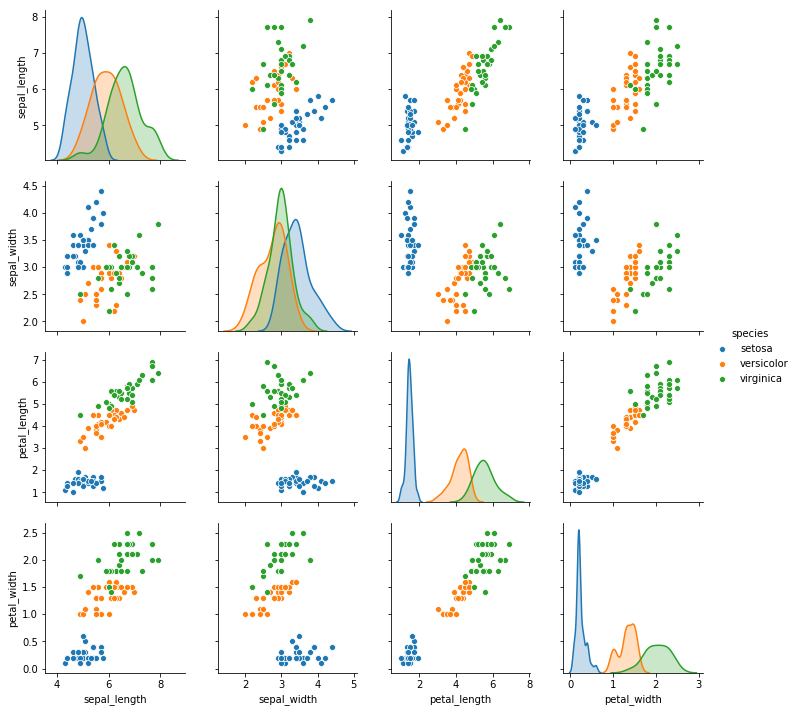

In [34]:
sns.pairplot(sample_df, hue='species', height=2.5);

In [ ]:
sns.pairplot(iris, hue='species', height=2.5);

In [12]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="species ~ .")

In [13]:
fittedRF = supervised.fit(df)  # fit the transformer

In [14]:
preparedDF = fittedRF.transform(df)  # transform

In [16]:
preparedDF.show(3)

+------------+-----------+------------+-----------+-------+-----------------+-----+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|label|
+------------+-----------+------------+-----------+-------+-----------------+-----+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|  2.0|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|  2.0|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|  2.0|
+------------+-----------+------------+-----------+-------+-----------------+-----+
only showing top 3 rows



In [21]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model.
kmeans = KMeans(k=3, seed=843)
model = kmeans.fit(preparedDF)

# Make predictions
predictions = model.transform(preparedDF)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.7356596054332228
Cluster Centers: 
[5.9016129  2.7483871  4.39354839 1.43387097]
[5.006 3.428 1.462 0.246]
[6.85       3.07368421 5.74210526 2.07105263]


## Principal Component Analysis - PCA

In [22]:
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.linalg import Vectors

In [23]:
pca = PCAml(k=2, inputCol="features", outputCol="pca")
model = pca.fit(preparedDF)
transformed = model.transform(preparedDF)

In [25]:
transformed.show(2, False)

+------------+-----------+------------+-----------+-------+-----------------+-----+----------------------------------------+
|sepal_length|sepal_width|petal_length|petal_width|species|features         |label|pca                                     |
+------------+-----------+------------+-----------+-------+-----------------+-----+----------------------------------------+
|5.1         |3.5        |1.4         |0.2        |setosa |[5.1,3.5,1.4,0.2]|2.0  |[-2.818239506639473,-5.646349823412759] |
|4.9         |3.0        |1.4         |0.2        |setosa |[4.9,3.0,1.4,0.2]|2.0  |[-2.788223445314683,-5.1499513517628674]|
+------------+-----------+------------+-----------+-------+-----------------+-----+----------------------------------------+
only showing top 2 rows

